<a href="https://colab.research.google.com/github/flavia-segadilha/Neuronio-Perceptron_2025_1/blob/main/NeuronioPerceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Neurais Artificiais – Projeto Prático 2.1
## Aprendizado Supervisionado no Neurônio Perceptron
Neste projeto prático, o objetivo é implementar o algoritmo de treinamento mediante Aprendizado Supervisionado do neurônio Perceptron de Rosenblatt aplicado em problemas de classificação.

---

### Equipe:


*   Adriana Raffaella Dos Santos Fonseca
*   Ana Flavia de Castro Segadilha da Silva
*   Guilherme Gonçalves Moraes
*   Yago De Oliveira Feitoza



## Bibliotecas

In [97]:
#Importação das bibliotecas
import gdown
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
from prettytable import PrettyTable
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

## Leitura de Dados

In [98]:
# Baixar o arquivo do Google Drive
gdown.download('https://drive.google.com/uc?export=download&id=18xVywKIw4WCCDXXAf-G-DflLfA5EQeeM', 'dataAll.txt', quiet=False)

# Carregar os dados binários diretamente para um numpy.ndarray
ndarray = np.fromfile('dataAll.txt', dtype=np.float64)

# A partir dos dados binários, reorganizar para a forma correta (m, 1, 3)
ndarray = ndarray.reshape(-1, 1, 3)

#Retirando a dimensão do meio
ndarray_2d = ndarray.reshape(-1, 3)

#DataFrame dos dados
data = pd.DataFrame(ndarray_2d, columns=['Dado 1', 'Dado 2', 'Y desejado'])

# Exibir as 5 primeiras linhas dos dados carregados
print(f'\n\n{data.head()}')

#Separando as variáveis X(input) e y_d (y desejado)
X = data[['Dado 1', 'Dado 2']].values #Exemplos da primeira e segunda coluna
y_d = data[['Y desejado']].values #Última coluna

Downloading...
From: https://drive.google.com/uc?export=download&id=18xVywKIw4WCCDXXAf-G-DflLfA5EQeeM
To: /content/dataAll.txt
100%|██████████| 24.0k/24.0k [00:00<00:00, 29.9MB/s]



     Dado 1    Dado 2  Y desejado
0 -363.7884  244.1423         0.0
1  328.7572 -256.7658         1.0
2 -164.9827  613.2164         0.0
3  536.5905  764.9575         0.0
4  314.2297  343.8375         0.0


## Parte I – Resolvendo um Problema Linearmente Separável

###Implementação do Neurônio Perceptron

In [99]:
class Perceptron:
    def __init__(self, n_inputs, taxa_aprendizado=0.1, max_epocas=1000):
        self.pesos = np.random.uniform(-0.5, 0.5, size=n_inputs + 1)
        self.taxa_aprendizado = taxa_aprendizado
        self.max_epocas = max_epocas
        self.epocas = 0
        self.ajuste_pesos = 0

    #Função degrau com θ=0
    def funcao_ativacao(self, x):
        return 1 if x >= 0 else 0

    def train(self, X, y):

        while self.epocas < self.max_epocas:
            erro_flag = False
            for xi, y_d in zip(X, y):
                xi_vies = np.insert(xi, 0, 1)
                y_p = self.funcao_ativacao(np.dot(xi_vies, self.pesos))
                error = y_d - y_p
                #Aplicação da Regra Delta
                if error != 0:
                    self.pesos += self.taxa_aprendizado * error * xi_vies
                    self.ajuste_pesos += 1
                    erro_flag = True
            self.epocas += 1
            if not erro_flag:
                break

    def grafico(self, X, y):

        # Plotando os dados e a reta de separação
        plt.figure(figsize=(8, 6))
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', label="Dados", s=40, edgecolors='k')

        # Ajuste para a linha de decisão
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min = (self.pesos[0] / self.pesos[2]) - (self.pesos[1] / self.pesos[2]) * x_min  # Cálculo para y_min
        y_max = (self.pesos[0] / self.pesos[2]) - (self.pesos[1] / self.pesos[2]) * x_max  # Cálculo para y_max


        # Linha de decisão (ajustada para destacar)
        plt.plot([x_min, x_max], [y_min, y_max], color='black', label='Linha de decisão', linewidth=2)

        # Estilizando o gráfico
        plt.xlabel('x_1', fontsize=12)
        plt.ylabel('x_2', fontsize=12)
        plt.title('Resultado', fontsize=14)
        plt.show()

###Resultados do Treinamento

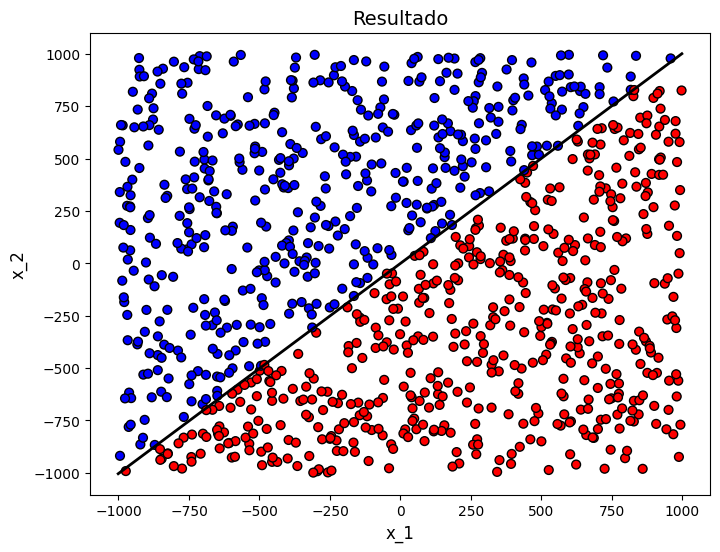

Pesos iniciais : [   0.48006344  218.33935461 -217.59890205]
Quantidade de ajustes no vetor de pesos: 24
Pesos finais após treinamento: [   0.48006344  218.33935461 -217.59890205]
Quantidade de épocas: 2



In [100]:
perceptron = Perceptron(n_inputs=X.shape[1])

pesos_iniciais = perceptron.pesos
perceptron.train(X, y_d)
perceptron.grafico(X, y_d)

print(f"Pesos iniciais : {pesos_iniciais}")
print(f"Quantidade de ajustes no vetor de pesos: {perceptron.ajuste_pesos}")
print(f"Pesos finais após treinamento: {perceptron.pesos}")
print(f"Quantidade de épocas: {perceptron.epocas}\n")

## Parte II – Experimentação

###Leitura do arquivo data3.txt

In [101]:
# Baixar o arquivo do Google Drive
gdown.download('https://drive.google.com/uc?export=download&id=1RoXGITcMlWDFydO8Y16Vw1MgPvpl6q75', 'data3.txt', quiet=False)

# Carregar os dados binários diretamente para um numpy.ndarray
ndarray = np.fromfile('data3.txt', dtype=np.float64)

# A partir dos dados binários, reorganizar para a forma correta (m, 1, 3)
ndarray = ndarray.reshape(-1, 1, 3)

#Retirando a dimensão do meio
ndarray_2d = ndarray.reshape(-1, 3)

#DataFrame dos dados
data3 = pd.DataFrame(ndarray_2d, columns=['Dado 1', 'Dado 2', 'Y desejado'])

# Exibir as 5 primeiras linhas dos dados carregados
print(f'\n\n{data3.head()}')

#Separando as variáveis X(input) e y_d (y desejado)
X = data3[['Dado 1', 'Dado 2']].values #Exemplos da primeira e segunda coluna
y_d = data3[['Y desejado']].values #Última coluna

Downloading...
From: https://drive.google.com/uc?export=download&id=1RoXGITcMlWDFydO8Y16Vw1MgPvpl6q75
To: /content/data3.txt
100%|██████████| 14.4k/14.4k [00:00<00:00, 21.3MB/s]



     Dado 1    Dado 2  Y desejado
0  0.061628 -0.124257         0.0
1 -0.125767 -0.203857         0.0
2  0.036252 -0.126108         0.0
3 -0.003661  0.023619         0.0
4 -0.154962  0.145064         0.0


### Listas de *η* e *I*

In [102]:
taxas_aprendizado = [0.4, 0.1, 0.01] # Possíveis valores para a Taxa de Apendizado
intervalos_pesos = [(-0.5, 0.5), (-100, 100)] # Possíveis valores para intervalo de peso

### Implementação do Neurônio Perceptron

In [103]:
class Perceptron:

    def __init__(self, n_inputs, taxa_aprendizado=0.01, max_epocas=1000, intervalo_pesos=(-100, 100)):
        self.pesos = np.random.uniform(intervalo_pesos[0], intervalo_pesos[1], size=n_inputs + 1)
        self.taxa_aprendizado = taxa_aprendizado
        self.max_epocas = max_epocas
        self.epocas = 0
        self.ajuste_pesos = 0
        self.intervalo_pesos = f'{intervalo_pesos[0]}, {intervalo_pesos[1]}'


    #Função degrau com θ=0
    def funcao_ativacao(self, x):
        return 1 if x >= 0 else 0

    def train(self, X, y):

        while self.epocas < self.max_epocas:
            erro_flag = False
            for xi, y_d in zip(X, y):
                xi_vies = np.insert(xi, 0, 1)
                y_p = self.funcao_ativacao(np.dot(xi_vies, self.pesos))
                error = y_d - y_p
                #Aplicação da Regra Delta
                if error != 0:
                    self.pesos += self.taxa_aprendizado * error * xi_vies
                    self.ajuste_pesos += 1
                    erro_flag = True
            self.epocas += 1
            if not erro_flag:
                break

    def calcular_media(self, ajustes_peso):
        return sum(ajustes_peso) / len(ajustes_peso)

    def calcular_minimo(self, todas_epocas):
        return min(todas_epocas)


### Inicialização da Tabela

In [104]:
table = PrettyTable()
table.field_names = ["Taxa de Aprendizado", "Intervalo de Pesos", "Quantidade de Ajustes", "Menor número de épocas para convergência"]

### Testes e resultados

In [105]:
ajustes_peso = [] # inicializando a lista vazia para cálculo de média
todas_epocas = [] # inicializando a lista vazia para achar a mínima quantidade de épocas para convergência


for taxa_aprendizados in taxas_aprendizado:
    for intervalo_peso in intervalos_pesos:

        repeticao = 0
        while repeticao <= 10:

            perceptron = Perceptron(n_inputs=X.shape[1], taxa_aprendizado=taxa_aprendizados, intervalo_pesos=intervalo_peso)
            perceptron.train(X, y_d)

            ajustes_peso.append(perceptron.ajuste_pesos)
            todas_epocas.append(perceptron.epocas)

            desvio_padrao = float(np.std(ajustes_peso))

            quantidade_ajuste = f'{perceptron.calcular_media(ajustes_peso):.2f} ± {desvio_padrao:.2f}'

            repeticao += 1

        table.add_row([perceptron.taxa_aprendizado, perceptron.intervalo_pesos, quantidade_ajuste , perceptron.calcular_minimo(todas_epocas)])

print(table)

+---------------------+--------------------+-----------------------+------------------------------------------+
| Taxa de Aprendizado | Intervalo de Pesos | Quantidade de Ajustes | Menor número de épocas para convergência |
+---------------------+--------------------+-----------------------+------------------------------------------+
|         0.4         |     -0.5, 0.5      |      7.91 ± 3.29      |                    3                     |
|         0.4         |     -100, 100      |    141.36 ± 158.00    |                    3                     |
|         0.1         |     -0.5, 0.5      |     97.27 ± 143.30    |                    2                     |
|         0.1         |     -100, 100      |    379.93 ± 615.16    |                    2                     |
|         0.01        |     -0.5, 0.5      |    316.07 ± 565.06    |                    2                     |
|         0.01        |     -100, 100      |   2429.98 ± 5023.66   |                    2               